# Computing time-resolved spectra from the NA-MD calculations 


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

   2.1. [Overview](#2.1)

   2.2. [Example](#2.2)

4. [Calculations](#3)

   3.1. [Pentacene calculations](#3.1)

   3.2. [Pentacene visualization](#3.2)

   3.3. [TiO2 example](#3.3)



## A. Learning objectives

- to know how energy profiles can be convolved with the populations from NA-MD for multiple initial conditions
- to learn how to visualize population dynamics in energy scale of a given problem
- to know how to visualize time-resolved spectra in different color schemes
- to know how to compute time-resolved spectra using different file types of input files


## B. Use cases

- Compute time-resolved spectra
- Read the HDF5 files to plot results of dynamical calculations

## C. Functions

- `libra_py`
  - `trpes`
    - [`compute_trpes`](#compute_trpes-1)
    - [`plot_trpes`](#plot_trpes-1)

## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries from the `trpes`  function and avoid showing warnings. 

In [1]:
import warnings
from libra_py import trpes
%matplotlib inline
warnings.filterwarnings("ignore")  # Turn off warnings

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWar

## 2. Theoretical background
<a name="2"></a>[Back to TOC](#TOC)

### 2.1. Overview 
<a name="2.1"></a>[Back to TOC](#TOC)

In this tutorial, we will learn to visualize the population dynamics in energy domain. This approach is particularly appealing since it can be related to typical time-resolved absorption spectra (e.g. those reported in pump-probe experiments). In addition, this approach is more convenient for systems with large number of states. Because of high density of states, many of them would experience crossings or near crossings, leading to large nonadiabatic couplings and rapid population transitions between them. Visualizing sub-10-fs decay curves for dozens of states isn't fun and can clutter your figure very fast. In addition, state populations are not observable (because there is no Hermitian operator whose eigenvalues would be the state populations). Thus, they are unphysical, strictily speaking, and can not be obtained from experiments directly (although, of course, they can be computed exactly). 

For all these reasons, it is better to compute something that could resemble the experiment. The time-resolved occupations of the energy states - this is the kind of spectra we are going to learn to compute in this tutorial. As a possible alternative, one may compute the average excitation energy and characterize its relaxation. However, this approach gives only the averaged (so to say a "mean-field") picture. The same average excitation energy may be realized in a multitudes of ways. As the limiting examples, to have average energy of 1.0 eV, one may simply occupy (with 100% weight) such a state, at 1 eV (if it is present). Or one could occupy states with 0.0 eV excitation energy (ground state) and 2.0 eV - both with 50% weight. Knowing such a distribution and how it changes in time could provide mechanistic insights into excitation energy flow and dynamics in the problem of interest.  

### 2.2. Example
<a name="2.2"></a>[Back to TOC](#TOC)

Consider we have conducted 5 ps (so `fstep = 5000` steps with 1 fs time-step, `dt`) of the MD trajectory and use it for NBRA-NAMD calculations. Assume, we disregard the first 1 ps of it as "thermalization" (`istep = 1000`). Thus, we have 4 ps of data (energy levels and couplings) which is typically provided in files, so we read `nfiles = 4000` files. Now, imagine we need to comput a 6 ps (`namd_nsteps = 6000`) NA-MD trajectory with 4 initial conditions taken as the starting points at 1 ps, 2 ps, 3 ps, and 4 ps marks of the trajectory (`iconds = [1000, 2000, 3000, 4000]`) - Figure below. 

First, if we want 6 ps of NA-MD data (population dynamics) using only 4 ps of genuine data - it is likely that the dynamics is computed by using the "reperition" approach, in which the original `nfiles` files are repeated cyclically until the desired length of simulations is reached. Moreover, if the latest `iconds` is 4000, one needs energy data up until 6 + 4 = 10 ps, which is possible by doing a 3-fold repetition of the original energy/Hamiltonian data to reach overall of 1 + 3 * 4 = 13 ps "repeatd" trajectory. 

Note, that it doesn't make sense to set up the iconds to be larger than 5 ps in this case, because all of the timesteps larger than 5 ps are simply the repetitions of the existing genuine 4 ps of data. Thus, starting from `icond = [5500]` would be equivalent to starting with `icond = [1500]`.


![image](fig.png)

Once the preparatory steps are conducted, the TRPES is computed as:

$$
  I(t_i, E) = \frac{1}{N_{icond}} \sum_{k=1}^{N_{icond} } P_{j, k} (t_i) \Delta E \exp\left(-\frac{(E - E_{j, k} (t_i))^2}{2\sigma^2 }\right)
$$

Here:

- $P_{j, k} (t_i)$ - surface hopping population of state j for the initial condition k at time $t_i$
- $E_{j, k} (t_i)$ - energy of state j for the initial condition k at time $t_i$
- $N_{icond}$ - the number of valid initial conditions
- $\sigma$ - the energy broadening parameter (for smoothness of the resulting signal)
- $\Delta E$ - the spacing of the energy grid
- $E$ - the energy at which to evaluate the signal

In practice, before the above formula is used, the beginning of the NA-MD population data (red curves in the above figure) should be aligned with the corresponding starting points of the MD energy data after the one is cyclicly repeated (green curve in the above figure).


## 3. Calculations
<a name="3"></a>[Back to TOC](#TOC)

### 3.1. Pentacene calculations
<a name="3.1"></a>[Back to TOC](#TOC)

First, let's consider the pentacene data example with the matrix-type input data.

To get the calculations going, we first need to load the files. First, let's unpack the provided archive with the data provided:
Excitation energy data

In [2]:
! tar -xjf SD_basis_1.tar.bz2

and NA-MD data

In [3]:
! tar -xjf MSDM.tar.bz2

Next, we can read in all the files usin `trpes` function:

Some key parameters:

<a name="compute_trpes-1"></a>

In [4]:
help(trpes.compute_trpes)

Help on function compute_trpes in module libra_py.trpes:

compute_trpes(_params)
    Args:
        params (dict): control parameters. Can contain keywords:
    
        - istep ( int ): the first file to read, should be the same as used in NAMD [default: 1]
        - fstep ( int ): the last file to read, should be the same as used in NAMD [default: 10]
        - dt ( int ): time step in fs [ default: 1.0 ]
        - namd_nsteps ( int ): how many NAMD steps were computed in the dynamics. This may be 
          larger than the number of files read - in this case the (fsteps - istep) files will be
          repeated until the desired number of steps, `namd_nsteps` is met [ default: fstep - istep - 1]
        - input_file_type ( int ): the kind of files to get the energy from:
           - 0 : matrix-like Hvib files [ default ]
           - 1 : CP2K logfiles
           - 2 : .npz matrix-like Hvib files 
        - logfile_read_params ( dict ) : additional parameters to read the logfiles (on

**Things to keep in mind:**

- The `namd_nsteps` does not have to be equal to the actual length of the NA-MD data available. In the example below, we have 1772 energy files and the equivalent length of the SH population data, but we decide to compute the TRPES for only 1500 steps.

- Make sure you use the correct `dt`, consistent with your NA-MD simulations (and step2 data). Often the dt is 1 (fs), but in some cases the MD and NA-MD are integrated using other values of `dt` - they should translate to this calculation as well

- `istep` and `fstep` parameters should be chosed exactly as they were used in the NA-MD calculations, especially if trajectory repetitions were used in such calculations. They define the periodicity of energy data repetition, which affects the resulting population dynamics. One can not repeat the 4 ps of trajectory in the NA-MD calculations an use, say, 1 ps `nfiles` in the present calculations - then the energy levels and populations will be inconsistent and the convolution would be incorrect. 

In [5]:
x = {"istep": 1, "fstep": 1772, "dt":1.0, "namd_nsteps":1500, 
     "eprefix":"SD_basis_1/Hvib_sd_", "esuffix":"_re", "units":"Ha",
     "input_file_type":0, "logfile_read_params":{},
     "iconds":[1, 201, 401, 601, 801, 1001], "dprefix":"MSDM/MSDM_new66_icond_",
     "dsuffix":"/mem_data.hdf",
     "de":0.1, "emin":2.0, "emax":4.0, "sigma_e":0.5
    }
time_bins, energy_grid, H_total = trpes.compute_trpes(x)

{'istep': 1, 'fstep': 1772, 'dt': 1.0, 'namd_nsteps': 1500, 'eprefix': 'SD_basis_1/Hvib_sd_', 'esuffix': '_re', 'units': 'Ha', 'input_file_type': 0, 'logfile_read_params': {}, 'iconds': [1, 201, 401, 601, 801, 1001], 'dprefix': 'MSDM/MSDM_new66_icond_', 'dsuffix': '/mem_data.hdf', 'de': 0.1, 'emin': 2.0, 'emax': 4.0, 'sigma_e': 0.5}
Trajectory data contains 1771, while we only want 1500
The TRPES plot will be of the time legnth of 1500 points
The multiplication factor is 2
The shape of the effective E array is (1500, 37)
Initial iconds = [1, 201, 401, 601, 801, 1001]
Renormalizing iconds for istep = 1, fstep = 1772 and nsteps = 1500...
The effective iconds are = [1, 201, 401, 601, 801, 1001] (dropping off meaningless iconds)
Reading the file MSDM/MSDM_new66_icond_1/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_201/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_401/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_601/mem_data.hdf
Reading the file MSDM/MSDM_new66_icond_801/

In [6]:
help(trpes.plot_trpes)

Help on function plot_trpes in module libra_py.trpes:

plot_trpes(t_grid, e_grid, trpes, _plt_params)
    Args:
        t_grid ( np.array(nsteps)) : time grid [units: no units]
        e_grid ( np.array(n_e_grid_pts) ): energy grid [units: eV]
        trpes ( np.array(nsteps, n_e_grid_pts)) : TRPES - time-resolved potential energy surface
        plt_params (dict): control parameters. Can contain keywords:
        
        - fig_size ( [2-ints list]): aspect ratio and size of the figure [ default: [8,3] ] 
        - cmap_name ( string ): name of the color map [ default: "rainbow" ]
        - cfont_size ( int ): size of the fonts of the color bar [ default: 20 ]
        - ctick_size ( int ): size of the labels for the color bar tics [ default: 16 ]
        - xlabel_size ( int ): font size for the x label [ default: 20 ]
        - xtick_size ( int ): font size for the x ticks [ default: 16]
        - ylabel_size ( int ): font size for the y label [ default: 20 ]
        - ytick_size ( in

### 3.2. Pentacene visualization
<a name="3.2"></a>[Back to TOC](#TOC)

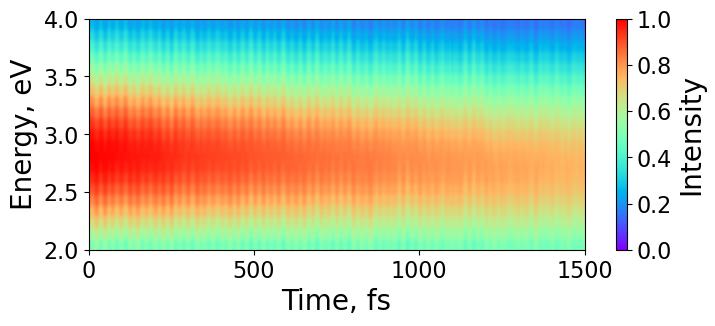

In [7]:
trpes.plot_trpes(time_bins, energy_grid, H_total, { } )

More examples of visual color schemes:

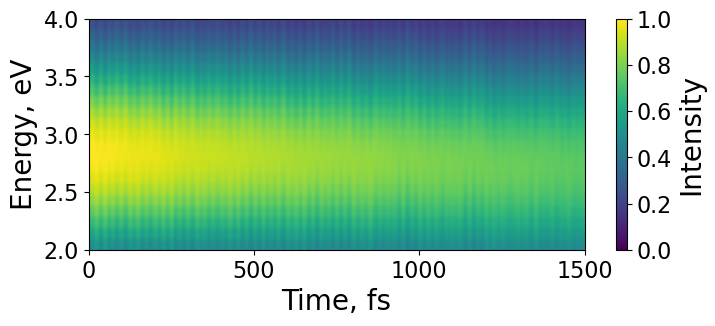

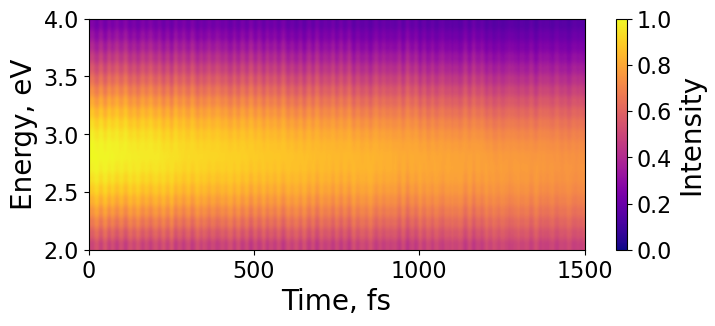

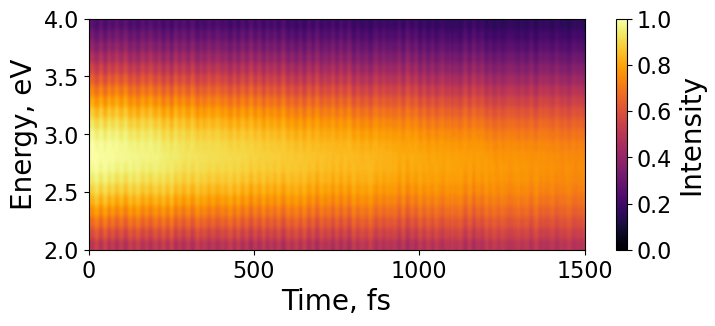

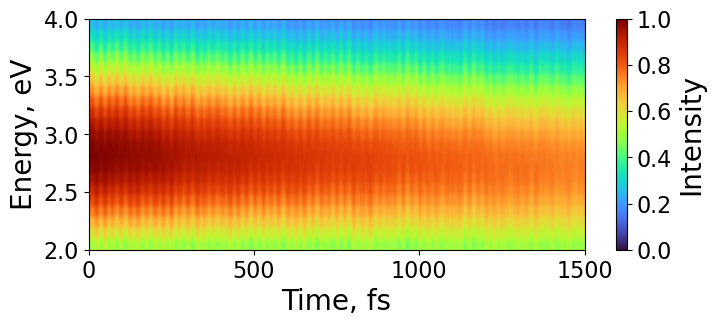

In [8]:
cmaps = ["viridis", "plasma", "inferno", "turbo"]

# Uniform definition of parameters to prevent warnings caused by missing default parameters
params = {
    "do_show": False,  
    "do_save": False,  
    "time_units": "fs",
    "energy_units": "eV",
    "fig_size": [8, 3],
    "cfont_size": 20,
    "ctick_size": 16,
    "xlabel_size": 20,
    "xtick_size": 16,
    "ylabel_size": 20,
    "ytick_size": 16,
    "figurename": "trpes.png",
    "dpi": 300
}

for cmap in cmaps:
    params["cmap_name"] = cmap  
    trpes.plot_trpes(time_bins, energy_grid, H_total, params)  

### 3.3. TiO2 example
<a name="3.3"></a>[Back to TOC](#TOC)

In this example, we will compute the TRPES using the CP2K files ".log" containing the excited state energies from TD-DFT calculations. This is instead of providing such data as Hamiltonian matrices.

In [9]:
!tar -xjf tio2.tar.bz2

In [10]:
x = {"istep": 1000, "fstep": 3990, "dt":1.0, "namd_nsteps":1000, "units":"eV",
     "eprefix":"tio2/logfiles/step_", "esuffix":".log",
     "input_file_type":1, "logfile_read_params": {"number_of_states":12},
     "iconds":[1, 201, 401, 1001], "dprefix":"tio2/iconds/MSDM_icond_",
     "dsuffix":"/mem_data.hdf",
     "de":0.1, "emin":0.0, "emax":5.5, "sigma_e":0.25
    }
time_bins, energy_grid, H_total = trpes.compute_trpes(x)

{'istep': 1000, 'fstep': 3990, 'dt': 1.0, 'namd_nsteps': 1000, 'units': 'eV', 'eprefix': 'tio2/logfiles/step_', 'esuffix': '.log', 'input_file_type': 1, 'logfile_read_params': {'number_of_states': 12}, 'iconds': [1, 201, 401, 1001], 'dprefix': 'tio2/iconds/MSDM_icond_', 'dsuffix': '/mem_data.hdf', 'de': 0.1, 'emin': 0.0, 'emax': 5.5, 'sigma_e': 0.25}
Trajectory data contains 6000, while we only want 1000
The TRPES plot will be of the time legnth of 1000 points
The multiplication factor is 1
The shape of the effective E array is (1000, 13)
Initial iconds = [1, 201, 401, 1001]
Renormalizing iconds for istep = 1000, fstep = 3990 and nsteps = 1000...
The effective iconds are = [1, 201, 401, 1001] (dropping off meaningless iconds)
Reading the file tio2/iconds/MSDM_icond_1/mem_data.hdf
Reading the file tio2/iconds/MSDM_icond_201/mem_data.hdf
Reading the file tio2/iconds/MSDM_icond_401/mem_data.hdf
Reading the file tio2/iconds/MSDM_icond_1001/mem_data.hdf


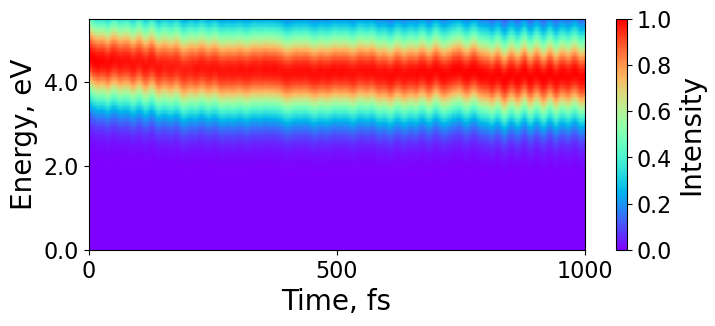

In [11]:
trpes.plot_trpes(time_bins, energy_grid, H_total, { } )